<a href="https://colab.research.google.com/github/ronaldnunes/Fruits-classification-w-pytorch/blob/main/FruitsCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARREGANDO AS BIBLIOTECAS

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import os
import matplotlib.pyplot as plt
from google.colab import files

# MANIPULANDO OS DADOS


In [3]:
from google.colab import files

# Faça o upload do arquivo Fruits360.zip do seu computador (disponível para baixar no repositório)
uploaded = files.upload()

Saving Fruits360.zip to Fruits360.zip


In [4]:
!unzip Fruits360.zip # Descompactar os arquivos

Archive:  Fruits360.zip
   creating: Fruits360/
   creating: Fruits360/test/
   creating: Fruits360/test/Apple Red 1/
  inflating: Fruits360/test/Apple Red 1/321_100.jpg  
  inflating: Fruits360/test/Apple Red 1/322_100.jpg  
  inflating: Fruits360/test/Apple Red 1/323_100.jpg  
  inflating: Fruits360/test/Apple Red 1/324_100.jpg  
  inflating: Fruits360/test/Apple Red 1/325_100.jpg  
  inflating: Fruits360/test/Apple Red 1/326_100.jpg  
  inflating: Fruits360/test/Apple Red 1/327_100.jpg  
  inflating: Fruits360/test/Apple Red 1/32_100.jpg  
  inflating: Fruits360/test/Apple Red 1/33_100.jpg  
  inflating: Fruits360/test/Apple Red 1/34_100.jpg  
  inflating: Fruits360/test/Apple Red 1/35_100.jpg  
  inflating: Fruits360/test/Apple Red 1/36_100.jpg  
  inflating: Fruits360/test/Apple Red 1/37_100.jpg  
  inflating: Fruits360/test/Apple Red 1/38_100.jpg  
  inflating: Fruits360/test/Apple Red 1/39_100.jpg  
  inflating: Fruits360/test/Apple Red 1/3_100.jpg  
  inflating: Fruits360/test/

In [5]:
path_train = "/content/Fruits360/training"
path_test = "/content/Fruits360/test"

In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),           # Inverter horizontalmente com 50% de probabilidade
    transforms.RandomRotation(15),              # Rotação aleatória de até 15 graus
    transforms.RandomResizedCrop((64, 64)),     # Recorte e redimensionamento aleatórios
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Ajustes de cores
    transforms.ToTensor(),                      # Converter para tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar os valores
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensionar as imagens
    transforms.ToTensor(),       # Converter para tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar os valores
])

In [7]:
data_train = datasets.ImageFolder(path_train, transform=train_transform)
data_test = datasets.ImageFolder(path_test, transform=test_transform)

In [ ]:
imgs = torch.stack([img_t for img_t, _ in data_train], dim=3)
imgs.shape

torch.Size([3, 64, 64, 1720])

In [8]:
train_loader = DataLoader(data_train, batch_size=96, shuffle=True)
test_loader = DataLoader(data_test, batch_size=96, shuffle=False)

# CONSTRUINDO UMA REDE CONVOLUCIONAL PRÓPRIA

DEFININDO A ARQUITETURA DA REDE

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(32 * 16 * 16, 128),
        nn.ReLU(),
        nn.Linear(128, 3)
    )

  def forward(self, x):
    return self.layers(x)



In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
ConvNet = ConvNet().to(device)

loss_function = nn.CrossEntropyLoss()  # DEFININDO A FUNÇÃO DE PERDA (ENTROPIA CRUZADA)
optimizer = torch.optim.Adam(ConvNet.parameters(), lr=0.0001)  # DEFININDO O OTIMIZADOR (ADAM)

# CONTRUINDO UM MODELO RESNET

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

ResNet = models.resnet18(pretrained=True)

n_features = ResNet.fc.in_features
ResNet.fc = nn.Linear(n_features, 3)
ResNet = ResNet.to(device)

loss_function = nn.CrossEntropyLoss()  # DEFININDO A FUNÇÃO DE PERDA (ENTROPIA CRUZADA)
optimizer = torch.optim.Adam(ResNet.parameters(), lr=0.0001)  # DEFININDO O OTIMIZADOR (ADAM)

# TREINAMENTO, MÉTRICAS E PREDIÇÕES

FUNÇÃO DE TREINAMENTO

In [10]:
def Train(model, dataloader, loss_func, optimizer):
    model.train()
    cost = 0.0
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      optimizer.zero_grad()

      pred = model(imgs)

      loss = loss_func(pred, labels)
      loss.backward()
      optimizer.step()

      cost += loss.item()

    return cost / len(dataloader)

FUNÇÃO DE VALIDAÇAO


In [11]:
def Validate(model, dataloader, loss_function):
  model.eval()
  cost = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_function(pred, labels)
      cost += loss.item()

  return cost / len(dataloader)

FUNÇÃO PARA CALCULAR ACURÁCIA

In [12]:
def Acuracy(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  # Itere sobre o conjunto de dados de teste
  with torch.no_grad():  # Desative o cálculo de gradientes durante a avaliação
      for data in test_loader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  # Calcule a acurácia
  accuracy = 100 * correct / total
  print(f"Acurácia no conjunto de teste: {accuracy:.2f}%")

FUNÇÃO PARA PLOTAR A CURVA DE APRENDIZADO

In [13]:
def learning_curve(errors):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in errors.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteração", fontsize="16")
  ax.set_ylabel("Erro", fontsize="16")
  ax.set_title("Erro vs Iterações", fontsize="16");

TREINANDO A NOSSA REDE CONVOLUCIONAL


In [ ]:
model = ConvNet #Selecione o modelo (ResNet, ou ConvNet)
epochs = 10
train_costs = []
test_costs = []
for t in range(epochs):
  train_cost = Train(model, train_loader, loss_function, optimizer)
  train_costs.append(train_cost)

  test_cost = Validate(model, test_loader, loss_function)
  test_costs.append(test_cost)

  print(f"Epoch: {t+1}; Train Loss: {train_cost}")

print("FIM")


CURVA DE APRENDIZADO

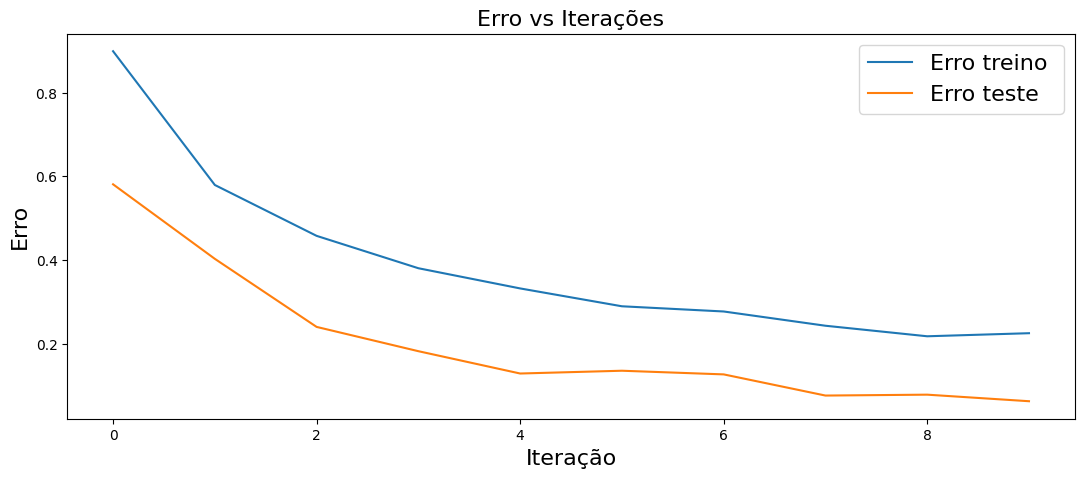

In [ ]:
errors = {"Erro treino ": train_costs, "Erro teste": test_costs}
learning_curve(errors)

ACURÁCIA

In [ ]:
Acuracy(model, test_loader)

Acurácia no conjunto de teste: 100.00%


TREINANDO A REDE RESNET

In [ ]:
model = ResNet #Selecione o modelo (ResNet, ou ConvNet)
epochs = 10
train_costs = []
test_costs = []
for t in range(epochs):
  train_cost = Train(model, train_loader, loss_function, optimizer)
  train_costs.append(train_cost)

  test_cost = Validate(model, test_loader, loss_function)
  test_costs.append(test_cost)

  print(f"Epoch: {t+1}; Train Loss: {train_cost}")

print("FIM")

CURVA DE APRENDIZADO

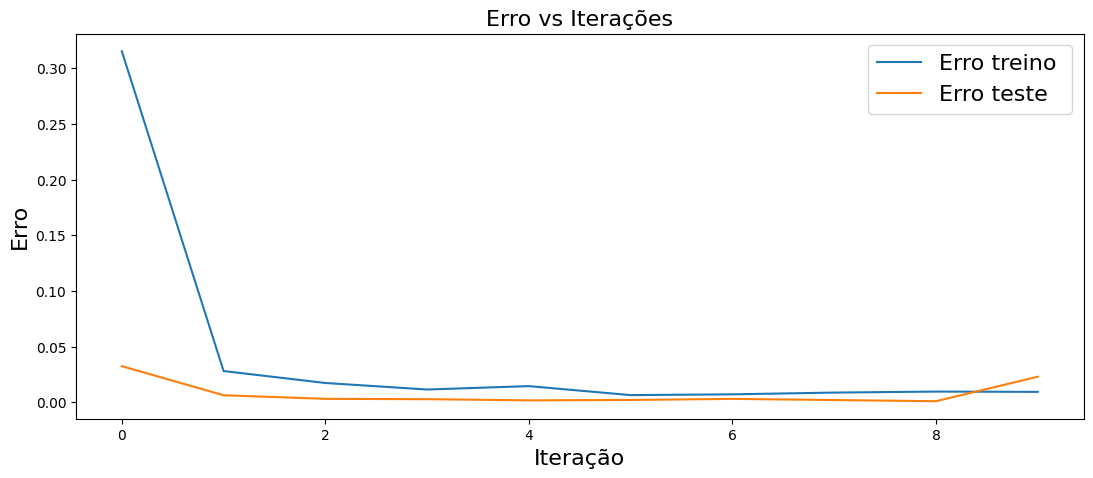

In [19]:
errors = {"Erro treino ": train_costs, "Erro teste": test_costs}
learning_curve(errors)

ACURÁCIA

In [20]:
Acuracy(model, test_loader)

Acurácia no conjunto de teste: 100.00%
